<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод:" data-toc-modified-id="Промежуточный-вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод:" data-toc-modified-id="Промежуточный-вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Промежуточный вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LInear-Regression" data-toc-modified-id="LInear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LInear Regression</a></span><ul class="toc-item"><li><span><a href="#with-rolling-window" data-toc-modified-id="with-rolling-window-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>with rolling window</a></span></li><li><span><a href="#with-cross_val" data-toc-modified-id="with-cross_val-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>with cross_val</a></span></li></ul></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Промежуточный-вывод:" data-toc-modified-id="Промежуточный-вывод:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Промежуточный вывод:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
try:
    data = pd.read_csv("taxi.csv",index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [3]:
data.index.is_monotonic

True

In [4]:
data = data.resample('1H').sum()

In [5]:
adfuller(data)

(-3.0689242890279536,
 0.028940051402613094,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

In [6]:
new_data = data - data.shift()

In [7]:
new_data = new_data.fillna(0)

In [8]:
adfuller(new_data)

(-15.800080747734183,
 1.0766445375117046e-28,
 31,
 4384,
 {'1%': -3.4318425029781716,
  '5%': -2.862199504531929,
  '10%': -2.5671210585627398},
 41728.74824680274)

In [9]:
data.isna().sum()

num_orders    0
dtype: int64

### Промежуточный вывод:
В данной главе мы проверили данные на монотонность(правильный ли порядок значений индекса) и стационарность, где данные оказались не стационарными так как `p-value` = 0.02 < 0.5, это говорит о нестационарныости, после чего создали новые данные со сдвигом, чтобы они были пригодными для анализа. Также провели ресемплирование данных по одному часу и проверили данные на пропуски.

## Анализ

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [11]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


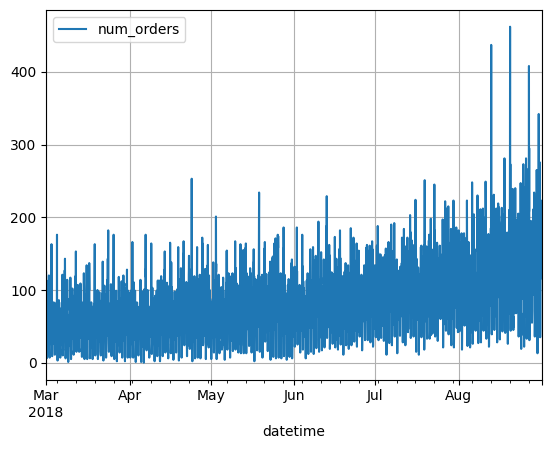

In [12]:
data.plot(grid=True)
plt.show()

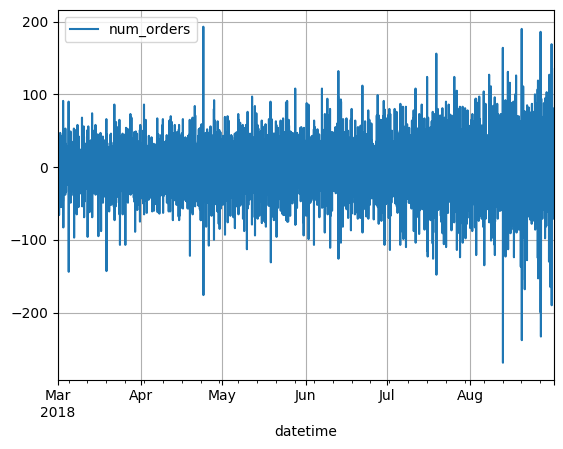

In [13]:
new_data.plot(grid=True)
plt.show()

In [19]:
result = seasonal_decompose(data, model='additive')

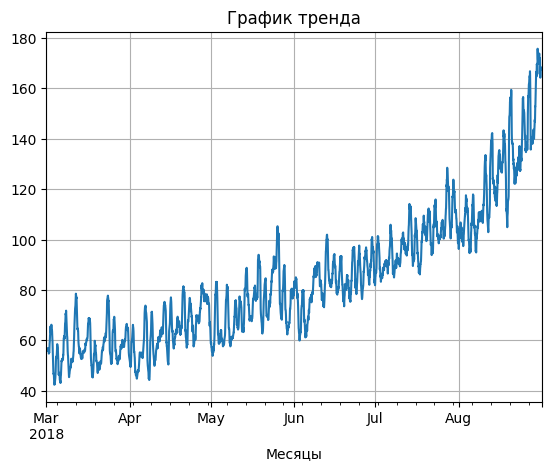

In [20]:
result.trend.plot(grid=True)
plt.title('График тренда')
plt.xlabel('Месяцы', fontsize = 10)
plt.show()

In [21]:
#data.resample('1W').sum().plot(grid=True)
#plt.title('Тренд')
#plt.xlabel('Месяцы', fontsize = 15)
#plt.show()

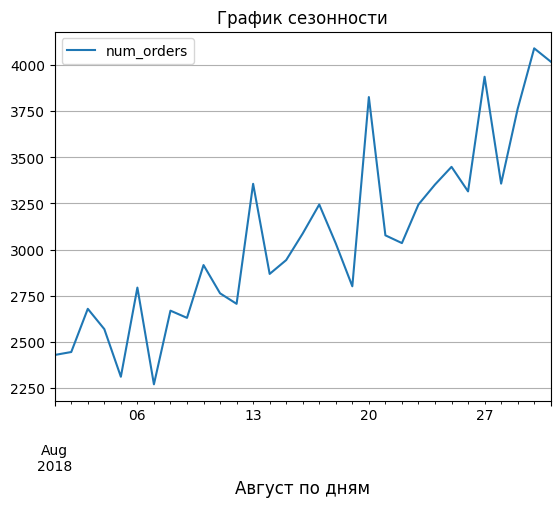

In [22]:
data.resample('1D').sum().loc["2018-08":].plot(grid=True)
plt.title('График сезонности')
plt.xlabel('Август по дням', fontsize = 12)
plt.show()

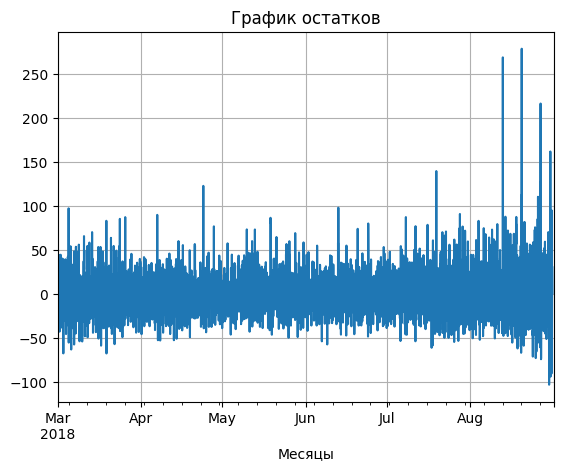

In [23]:
result.resid.plot(grid=True)
plt.title('График остатков')
plt.xlabel('Месяцы', fontsize = 10)
plt.show()

### Промежуточный вывод:
В данной главе была построены графики: 

    1)Тренда, который показывает, что количество заказов такси увеличивается с каждым месяцем, лето - время отпусков
    2)Сезонности, выбрали месяц август, самый пиковый по количеству заказов, до последнего дня августа количество заказов такси увеличивается(возможно люди возвращаются с отпусков)
    3)Остатка, который показывает, что данные являются приемлимыми для использования моделей.
Также вновь убедились что график со сдвигом - стационарный.

## Обучение

### LInear Regression

#### with rolling window

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    new_data['hour'] = new_data.index.hour
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(new_data, 24, 12)

In [25]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1)
train = train.dropna()

In [26]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
 
model = LinearRegression()
model.fit(features_train, target_train)
 
pred_train = model.predict(features_train)
linear_window=mean_squared_error(target_train, pred_train)**0.5
print("Метод скользящего окна")
print("RMSE тренировочной выборки:", linear_window)

Метод скользящего окна
RMSE тренировочной выборки: 25.850387140014632


#### with cross_val

In [33]:
tcsv = TimeSeriesSplit(n_splits=8)

In [34]:
model = LinearRegression()

linear_cross_val = abs(cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tcsv)).mean()
print('RMSE кросс валидацией:', linear_cross_val)

RMSE кросс валидацией: 26.630750632943816


### LightGBM

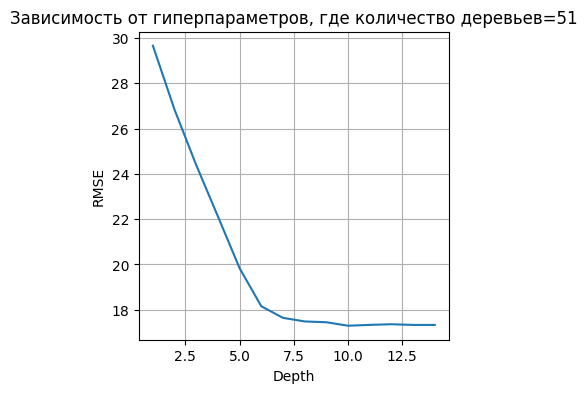

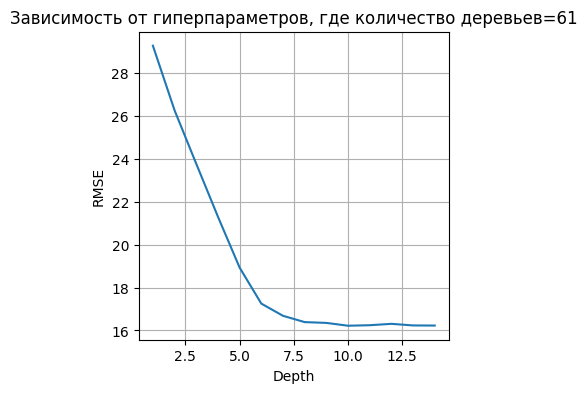

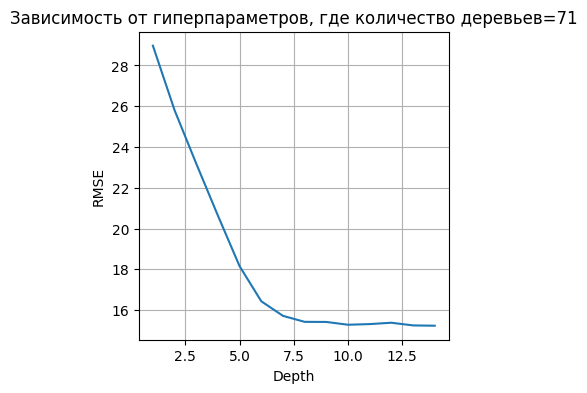

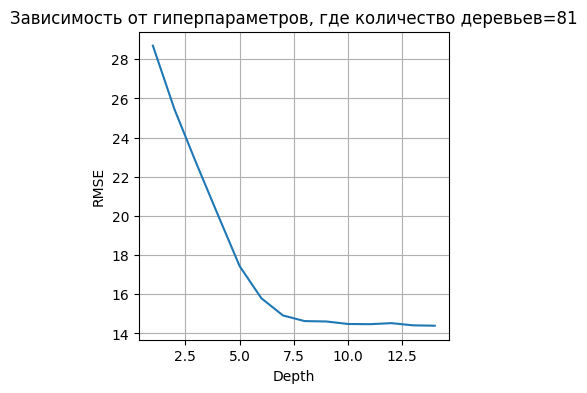

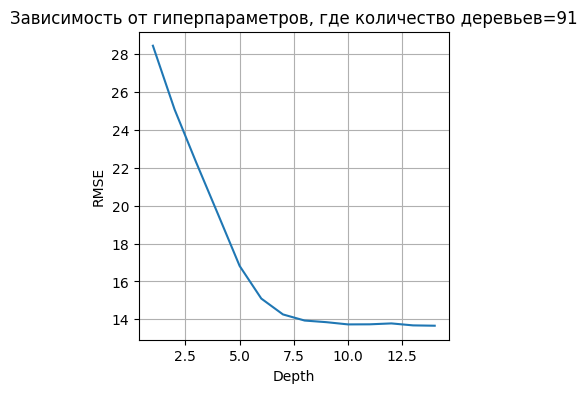

RMSE наилучшей модели на валидационной выборке: 13.659300148281007 Количество деревьев: 91 Максимальная глубина: 14
CPU times: total: 42.2 s
Wall time: 4.18 s


In [35]:
%%time
best_result = 48
best_model_LGBM = None
best_est = 0
best_depth = 0
c_depth = []
mse = []
n_estim = []

for n_est in range(51,101, 10):
    for depth in range(1,15):  
        model = lgb.LGBMRegressor(num_leaves=31, max_depth=depth, learning_rate=0.1, n_estimators=n_est, random_state=12345)
        model.fit(features_train, target_train)
        predicted = model.predict(features_train)
        result = (mean_squared_error(target_train, predicted))**0.5
        mse.append(result)
        c_depth.append(depth)
        n_estim.append(n_est)
  
        if result < best_result:
            best_model_LGBM = model
            best_result = result
            best_est = n_est
            best_depth = depth
    plt.figure(figsize=(4, 4))       
    plt.plot(c_depth, mse)
    c_depth = []
    mse = []
    n_estimators= []
    
    plt.title(f'Зависимость от гиперпараметров, где количество деревьев={n_est}')
    plt.xlabel('Depth')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()
    
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)  

### Промежуточный вывод:


Лучшей моделью является LightGBM

In [36]:
pd.DataFrame({'RMSE': [linear_window, linear_cross_val, best_result]},
            index = ["Linear_reg_roll_window", "Linear_reg_cross_val", 'LightGBM'])

,RMSE
Linear_reg_roll_window,25.850387
Linear_reg_cross_val,26.630751
LightGBM,13.659300


## Тестирование

In [37]:
best_model_LGBM
model.fit(features_train, target_train)
pred_test = model.predict(features_test)
print("RMSE тестовой выборки:", mean_squared_error(target_test, pred_test)**0.5)

RMSE тестовой выборки: 44.50005759298725


## Вывод:

В данной работе мы подготовили данные для анализа: Сделали временной ряд стационарным, также провели ресемплирование данных по одному часу, проанализировали графики тренда и сезонности, которые указывали на явное увеличение заказов такси в зависимости от месяца, также обучили различные модели, где лучшей оказалась LightGBM 